# Scenario Mining

In [1]:
def shift(array):
    l=list(array)
    l=[l[0]] + l
    l = l[:-1]
    return l

In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from moonlight import *
import numpy as np
from math import floor, ceil

In [3]:
import pandas as pd
import tables #required for read_hdf (Data is stored in tables format within hdf5 files)

from glob import glob

if __name__ == '__main__':
    # Load signal descriptions
    signal_descriptions = pd.read_csv('signal_descriptions.csv', index_col=0).squeeze().to_dict()
    # For all files:
    for file_path in glob('data/*.hdf5'):
        # Load as Pandas DataFrame
        df = pd.read_hdf(file_path)

In [4]:
df = df.rename(columns={'Time':'Time_stamp'})
df['Time'] = df.index
time = [t for t in df.Time]

In [5]:
max(df.Target_0_dy), min(df.Target_0_dy)

(34.44258526612157, -26.31124290782509)

## Pre-processing

In [6]:
identities = []

for k in range(8):
    identities = identities + list(df[f'Target_{k}_id'])
    
id_unique = list(set(identities))
trajectories = []

for i in id_unique:
    traj = []
    for k in range(8):
        t = df[df[f'Target_{k}_id'] == i][['Time',
                                           'Host_vx',
                                           'Host_ax',
                                           f'Target_{k}_dx', 
                                           f'Target_{k}_dy',
                                           f'Target_{k}_vx', 
                                           f'Target_{k}_ax']]
        t = t.rename(columns={f'Target_{k}_dx':'Target_dx', 
                              f'Target_{k}_dy':'Target_dy',
                              f'Target_{k}_vx':'Target_vx',
                              f'Target_{k}_ax':'Target_ax'})
        traj = traj + [t]
    trajectory = pd.concat(traj)
    trajectories = trajectories + [trajectory]  
    
for i in range(len(trajectories)):
    trajectories[i] = trajectories[i].sort_index()

In [7]:
span = np.zeros(len(trajectories)-1)
for k in range(1, len(trajectories)):
    span[k-1] = trajectories[k].index[-1] - trajectories[k].index[0]

print('min:', min(span),'\tmax:', max(span))
drop = [s+1 for s in range(len(span)) if span[s]<=3.5]
len(drop), len(trajectories)

min: 0.0 	max: 176.83999999999992


(3583, 4160)

In [8]:
usable_traj = [trajectories[d] for d in range(len(trajectories)) if d not in drop]

span = np.zeros(len(usable_traj)-1)
for k in range(1, len(usable_traj)):
    span[k-1] = usable_traj[k].index[-1] - usable_traj[k].index[0]

print('min:', min(span),'\tmax:', max(span))

min: 3.519999999999982 	max: 176.83999999999992


In [131]:
len(usable_traj)

577

## Cut-in

In [106]:
script_cutin = """
signal { real dx; real dy;  }
domain boolean;
formula cut_in = (dy>=3.5) until {(dx>=10) & (dy>=-0.1) & (dy<=0.1)};
"""

In [107]:
vel_ego = np.array([])
vel = np.array([])
cutins = []
indici = []

for j in range(1,len(usable_traj)):
    
    traj = usable_traj[j].copy()
    time = [t for t in traj.Time]
    
    # define the signals
    lst = list(zip(traj.Target_dx, traj.Target_dy))
    signals = [[s for s in signal] for signal in lst]
    
    # Moonlight monitor
    moon_cut_in = ScriptLoader.loadFromText(script_cutin)
    cut_in = moon_cut_in.getMonitor("cut_in")
    arr_cutin = np.array(cut_in.monitor(time, signals))
    
    # count the scenarios
    cutins = cutins + [sum(arr_cutin[:,1] == 1)]
    
    if cutins[j-1] != 0:
        indici = indici + [j]
    
    # extract velocities
    ind = [arr_cutin[i,0] for i in range(len(arr_cutin)) if arr_cutin[i,1] == 1]
    selected = traj.loc[traj.index.isin(ind)]
    rel_vel = selected.Target_vx
    ego_vel = selected.Host_vx
    vel = np.append(vel, rel_vel)
    vel_ego = np.append(vel_ego, ego_vel)

In [108]:
sum(cutins), len([id_unique[i] for i in indici])

(873, 140)

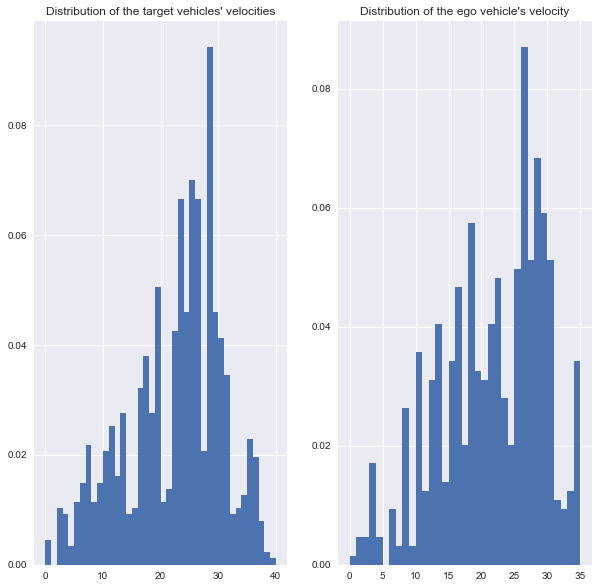

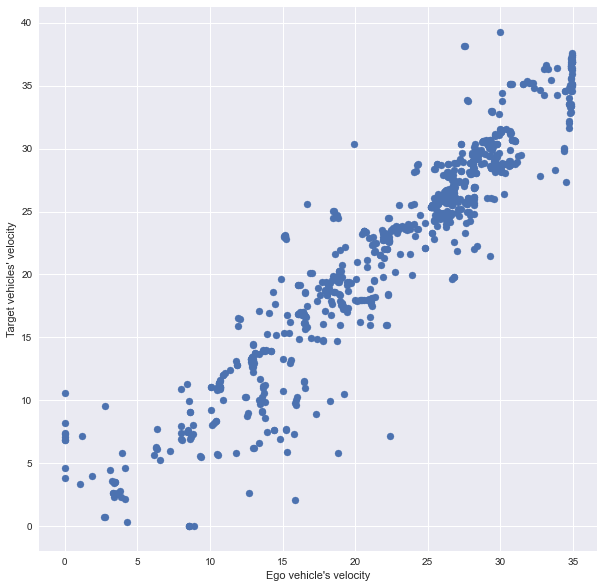

In [117]:
plt.rcParams["figure.figsize"] = (10,10)

# velocity in m/s
velocities = list(vel)
velocities_ego = list(vel_ego)
v_merge = list(zip(velocities_ego, velocities))

set_v = set(vel)
set_v_ego = set(vel_ego)

prob = [velocities.count(v)/len(velocities) for v in set_v]
prob_ego = [velocities_ego.count(v)/len(velocities_ego) for v in set_v_ego]

pdf = np.array(list(zip(set_v, prob)))
pdf_ego = np.array(list(zip(set_v_ego, prob_ego)))

figure, axis = plt.subplots(1,2)
axis[0].hist(pdf[:,0], bins=range(ceil(max(vel)) + 1), density=1)
axis[0].set_title("Distribution of the target vehicles' velocities")

axis[1].hist(pdf_ego[:,0], bins=range(ceil(max(vel_ego)) + 1), density=1)
axis[1].set_title("Distribution of the ego vehicle's velocity")
plt.show()


_=plt.scatter(velocities_ego, velocities)
_=plt.xlabel("Ego vehicle's velocity")
_=plt.ylabel("Target vehicles' velocity")

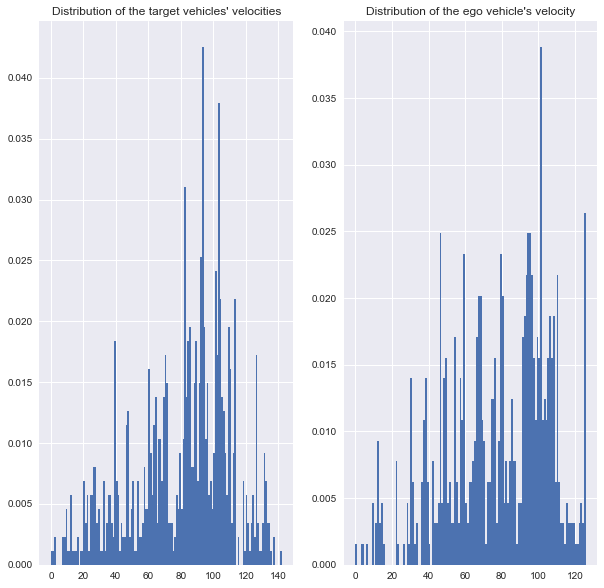

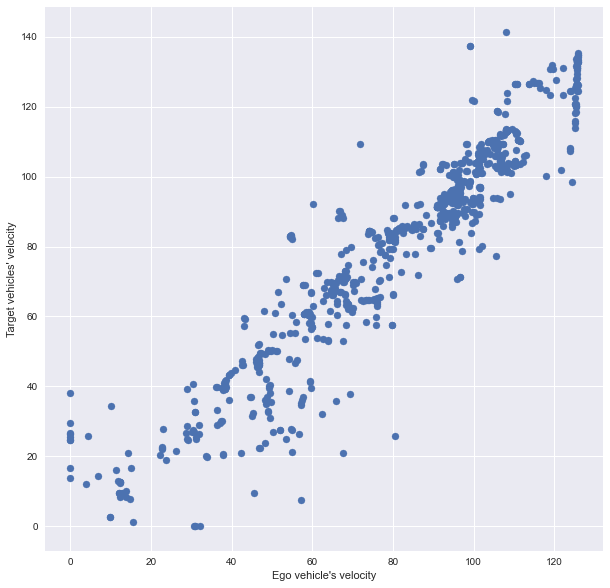

In [114]:
# velocity in km/h
vel_kmh = vel*3.6
vel_kmh_ego = vel_ego*3.6

velocities_kmh = list(vel_kmh)
velocities_kmh_ego = list(vel_kmh_ego)

set_kmh = set(vel_kmh)
set_kmh_ego = set(vel_kmh_ego)

prob_kmh = [velocities_kmh.count(v)/len(velocities_kmh) for v in set_kmh]
prob_kmh_ego = [velocities_kmh_ego.count(v)/len(velocities_kmh_ego) for v in set_kmh_ego]

pdf_kmh = np.array(list(zip(set_kmh, prob_kmh)))
pdf_kmh_ego = np.array(list(zip(set_kmh_ego, prob_kmh_ego)))

figure, axis = plt.subplots(1,2)
axis[0].hist(pdf_kmh[:,0], bins=range(ceil(max(vel_kmh)) + 1), density=1)
axis[0].set_title("Distribution of the target vehicles' velocities")

axis[1].hist(pdf_kmh_ego[:,0], bins=range(ceil(max(vel_kmh_ego)) + 1), density=1)
axis[1].set_title("Distribution of the ego vehicle's velocity")
plt.show()

_=plt.scatter(velocities_kmh_ego, velocities_kmh)
_=plt.xlabel("Ego vehicle's velocity")
_=plt.ylabel("Target vehicles' velocity")

In [14]:
v_merge
l = [(a,b) for a, b in v_merge if a>7.5 and b<5]
len(l), len(v_merge)-len(l)

(6, 867)

## Braking in front and minimal distance

In [122]:
script1 = """
signal { real d; real ego_ax; real other_ax; real ego_vx; }
domain boolean;
formula phi = ! globally[0,3] {(other_ax < 0)} | eventually[0,0.01] (ego_ax < 0);
formula boh =  eventually[0,0.5] (ego_ax < 0) ;
formula psi = (ego_vx > 20) & globally {d <= ((ego_vx/36) * (ego_vx/36))}; 
"""

In [123]:
vel_br = np.array([])
vel_br_ego = np.array([])
counts = []
indici_br = []

for j in range(1,len(usable_traj)):
    
    traj = usable_traj[j].copy()
    time = [t for t in traj.Time]
    
    # define the signals
    lst = list(zip(traj.Target_dx, traj.Host_ax, traj.Target_ax, traj.Host_vx))
    signals = [[s for s in signal] for signal in lst]
    
    # Moonlight monitor
    braking_moon = ScriptLoader.loadFromText(script1)
    braking = braking_moon.getMonitor("phi")
    arr_br = np.array(braking.monitor(time, signals))
    
    # count the scenarios
    counts = counts + [sum(arr_br[:,1] == 1)]
    
    if counts[j-1] != 0:
        indici_br = indici_br + [j]
    
    # extract velocities
    ind = [arr_br[i,0] for i in range(len(arr_br)) if arr_br[i,1] == 1]
    selected = traj.loc[traj.index.isin(ind)]
    rel_vel = selected.Target_vx
    ego_vel = selected.Host_vx
    vel_br = np.append(vel_br, rel_vel)
    vel_br_ego = np.append(vel_br_ego, ego_vel)

In [124]:
sum(counts)

1150

In [125]:
sum(counts), len([identities[i] for i in indici_br])

(1150, 504)

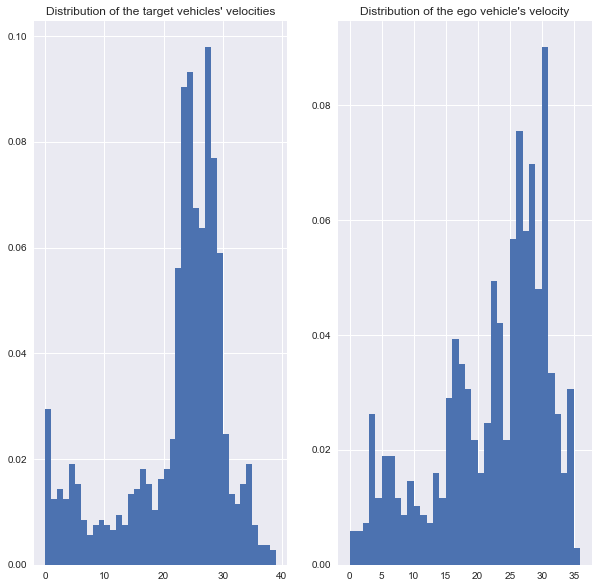

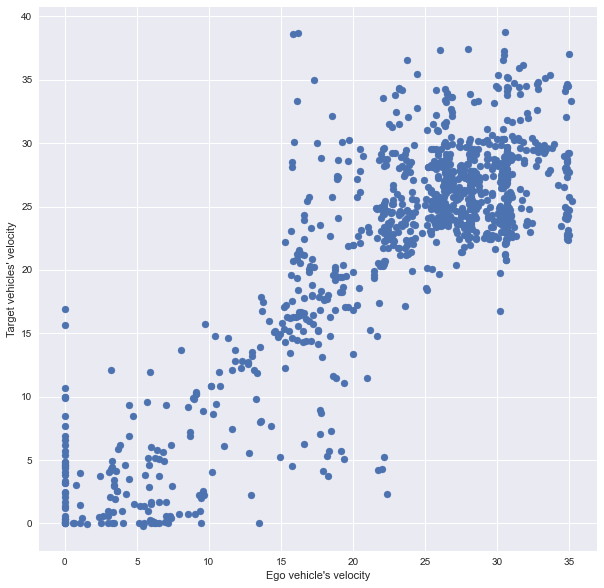

In [126]:
# velocity in m/s
velocities_br = list(vel_br)
velocities_br_ego = list(vel_br_ego)

set_v_br = set(vel_br)
set_v_br_ego = set(vel_br_ego)

prob_br = [velocities_br.count(v)/len(velocities_br) for v in set_v_br]
prob_br_ego = [velocities_br_ego.count(v)/len(velocities_br_ego) for v in set_v_br_ego]

pdf_br = np.array(list(zip(set_v_br, prob_br)))
pdf_br_ego = np.array(list(zip(set_v_br_ego, prob_br_ego)))

figure, axis = plt.subplots(1,2)
axis[0].hist(pdf_br[:,0], bins=range(ceil(max(vel_br)) + 1), density=1)
axis[0].set_title("Distribution of the target vehicles' velocities")

axis[1].hist(pdf_br_ego[:,0], bins=range(ceil(max(vel_br_ego)) + 1), density=1)
axis[1].set_title("Distribution of the ego vehicle's velocity")
plt.show()

_=plt.scatter(velocities_br_ego, velocities_br)
_=plt.xlabel("Ego vehicle's velocity")
_=plt.ylabel("Target vehicles' velocity")

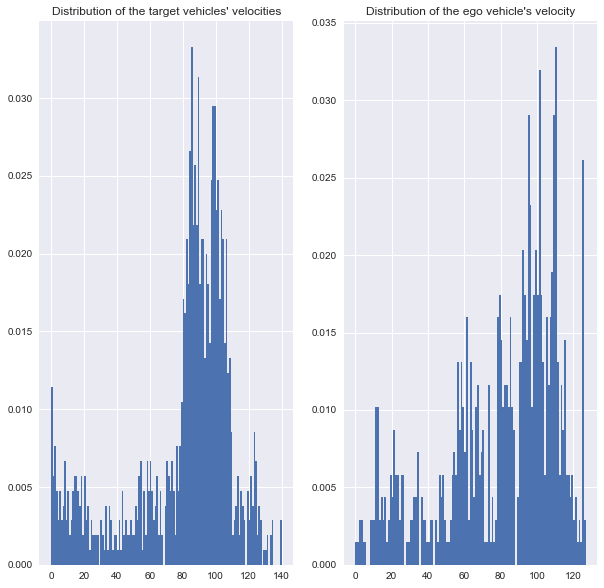

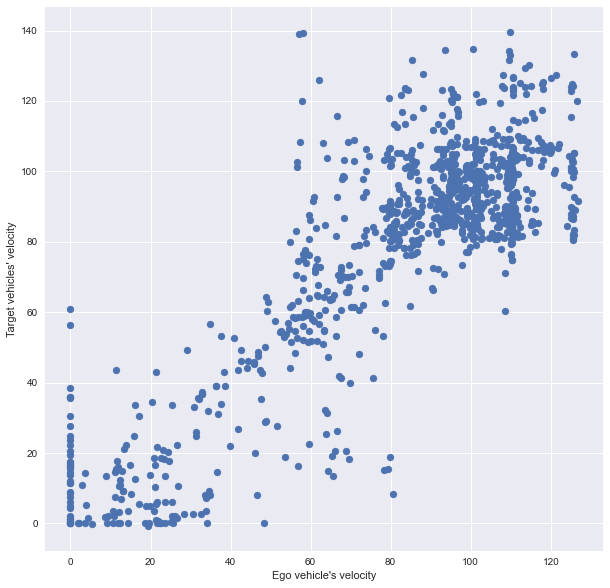

In [127]:
# velocity in km/h
vel_kmh_br = vel_br*3.6
vel_kmh_br_ego = vel_br_ego*3.6

velocities_kmh_br = list(vel_kmh_br)
velocities_kmh_br_ego = list(vel_kmh_br_ego)

set_kmh_br = set(vel_kmh_br)
set_kmh_br_ego = set(vel_kmh_br_ego)

prob_kmh_br = [velocities_kmh_br.count(v)/len(velocities_kmh_br) for v in set_kmh_br]
prob_kmh_br_ego = [velocities_kmh_br_ego.count(v)/len(velocities_kmh_br_ego) for v in set_kmh_br_ego]

pdf_kmh_br = np.array(list(zip(set_kmh_br, prob_kmh_br)))
pdf_kmh_br_ego = np.array(list(zip(set_kmh_br_ego, prob_kmh_br_ego)))

figure, axis = plt.subplots(1,2)

axis[0].hist(pdf_kmh_br[:,0], bins=range(ceil(max(vel_kmh_br)) + 1), density=1)
axis[0].set_title("Distribution of the target vehicles' velocities")

axis[1].hist(pdf_kmh_br_ego[:,0], bins=range(ceil(max(vel_kmh_br_ego)) + 1), density=1)
axis[1].set_title("Distribution of the ego vehicle's velocity")
plt.show()

_=plt.scatter(velocities_kmh_br_ego, velocities_kmh_br)
_=plt.xlabel("Ego vehicle's velocity")
_=plt.ylabel("Target vehicles' velocity")